In [1]:
from pyiron_atomistics import Project
import matplotlib.pylab as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression, RidgeCV
from scipy.spatial import cKDTree
from hashlib import sha1
from collections import defaultdict
from functools import cached_property
from magnetic_qha.src.collect_data import collect_data
from magnetic_qha.src.fitting import fit_parameters, get_structure, combine_fits
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = "retina"

/cmmc/ptmp/pyironhb/mambaforge/envs/pyiron_mpie_cmti_2025-08-11/lib/python3.11/site-packages/nglview/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
pr = Project("IRON")

In [3]:
a_bcc_range = np.linspace(2.8, 3, 11)
a_fcc_range = np.linspace(3.45, 3.65, 11)

In [4]:
class Structure:
    def __init__(self, a, crystalstructure, magmom=2, displacement=0, repeat=4, pr=pr):
        self.lattice_constant = a
        self.pr = pr
        self.repeat = repeat
        self.displacement = displacement
        self.cs = crystalstructure
        self.magmom = magmom

    def get_displacement(self, structure, pre_repeat=3 * [1]):
        repeat = np.array(3 * [self.repeat]) // np.array(pre_repeat)
        structure = structure.repeat(repeat)
        structure.positions[0, 0] += self.displacement
        return structure

    @property
    def uc(self):
        return self.pr.create.structure.bulk(
            "Fe", cubic=True, crystalstructure=self.cs, a=self.lattice_constant
        )

    @property
    def n(self):
        if self.displacement > 0:
            return self.get_displacement(self.uc)
        return self.uc
    
    @property
    def f(self):
        structure = self.uc
        structure.set_initial_magnetic_moments(len(structure) * [self.magmom])
        if self.displacement > 0:
            return self.get_displacement(structure)
        return structure
    
    @property
    def a(self):
        return self.get_a(plane=[0, 0, 1])
    
    @property
    def ax(self):
        if self.displacement > 0:
            return self.get_a(plane=[1, 0, 0])
        else:
            return self.a

    def get_a(self, plane=[0, 0, 1]):
        structure = self.uc
        m = np.array(len(structure) * [self.magmom])
        m[structure.analyse.get_layers(planes=plane)==1] *= -1
        structure.set_initial_magnetic_moments(m)
        if self.displacement > 0:
            return self.get_displacement(structure)
        return structure
    
    @property
    def d(self):
        return self.get_dq(plane=[0, 0, 1], n_repeat=1)
    
    @property
    def dx(self):
        if self.displacement > 0:
            return self.get_dq(plane=[1, 0, 0], n_repeat=1)
        else:
            return self.d

    def get_dq(self, plane=[0, 0, 1], n_repeat=1):
        repeat = (np.array(plane) + 1) * n_repeat
        structure = self.uc.repeat(repeat)
        m = np.array(len(structure) * [self.magmom])
        m[structure.analyse.get_layers(planes=plane) >= repeat.max()] *= -1
        structure.set_initial_magnetic_moments(m)
        if self.displacement > 0:
            return self.get_displacement(structure, pre_repeat=repeat)
        return structure
    
    @property
    def dd(self):
        return self.get_ddqq(plane=[0, 0, 1], n_repeat=1)
    
    @property
    def ddx(self):
        if self.displacement > 0:
            return self.get_ddqq(plane=[1, 0, 0], n_repeat=1)
        else:
            return self.dd

    def get_ddqq(self, plane=[0, 0, 1], n_repeat=1):
        repeat = (np.array((np.array(plane) + 1) % 2) + 1) * n_repeat
        structure = self.uc.repeat(repeat)
        planes = np.eye(3)
        planes = planes[np.ptp(planes - plane, axis=-1) > 0]
        m = np.array(len(structure) * [self.magmom])
        m *= np.prod((structure.analyse.get_layers(planes=planes) >= repeat.max()) * 2 - 1, axis=-1)
        structure.set_initial_magnetic_moments(m)
        if self.displacement > 0:
            return self.get_displacement(structure, pre_repeat=repeat)
        return structure
    
    @property
    def ddd(self):
        return self.get_dddqqq(3 * [2])

    @property
    def q(self):
        return self.get_dq(plane=[0, 0, 1], n_repeat=2)
    
    @property
    def qx(self):
        if self.displacement > 0:
            return self.get_dq(plane=[1, 0, 0], n_repeat=2)
        else:
            return self.q

    @property
    def qq(self):
        return self.get_ddqq(plane=[0, 0, 1], n_repeat=2)
    
    @property
    def qqx(self):
        if self.displacement > 0:
            return self.get_ddqq(plane=[1, 0, 0], n_repeat=2)
        else:
            return self.qq
    
    @property
    def qqq(self):
        return self.get_dddqqq(3 * [4])
        
    def get_dddqqq(self, repeat=[2, 2, 2]):
        structure = self.uc.repeat(repeat)
        m = np.array(len(structure) * [self.magmom])
        m *= np.prod((structure.analyse.get_layers() >= np.max(repeat)) * 2 - 1, axis=-1)
        structure.set_initial_magnetic_moments(m)
        if self.displacement > 0:
            return self.get_displacement(structure, pre_repeat=repeat)
        return structure



In [5]:
def get_structures(
    bcc=True, displacement=False, repeat=1, pr=pr, a_bcc_range=a_bcc_range, a_fcc_range=a_fcc_range
):
    if bcc:
        cs = "bcc"
        a_range = a_bcc_range
    else:
        cs = "fcc"
        a_range = a_fcc_range
    structures = defaultdict(list)
    for a in a_range:
        struct = Structure(a=a, crystalstructure=cs, displacement=displacement * 0.01)
        structures["n"].append(struct.n)
        structures["f"].append(struct.f)
        structures["a"].append(struct.a)
        structures["d"].append(struct.d)
        structures["dd"].append(struct.dd)
        structures["ddd"].append(struct.ddd)
        structures["q"].append(struct.q)
        structures["qq"].append(struct.qq)
        structures["qqq"].append(struct.qqq)
        if displacement:
            structures["ax"].append(struct.ax)
            structures["dx"].append(struct.dx)
            structures["ddx"].append(struct.ddx)
            structures["qx"].append(struct.qx)
            structures["qqx"].append(struct.qqx)
    return structures

In [6]:
def set_input(job, cores=120, queue='cm'):
    job.set_encut(550)
    div = (job.structure.analyse.get_layers().max(axis=0) + 1) // 2
    job.set_kpoints(mesh=3 * [16] // div)
    job.set_convergence_precision(electronic_energy=1.0e-6)
    job.set_mixing_parameters(
        density_mixing_parameter=0.5,
        density_residual_scaling=0.1,
        spin_mixing_parameter=0.5,
        spin_residual_scaling=0.1
    )   
    job.server.cores = cores
    if queue is not None:
        job.server.queue = queue


In [7]:

job = pr.wrap_python_function(collect_data)
job.input["project"] = pr
job.run()
data_dict = job.output.result


In [8]:

max_exp = 5
for cs, data in data_dict.items():
    structure = get_structure(cs)
    for index, positions in tqdm(enumerate(data["positions"]), total=len(data["positions"])):
        L = data["cell"][index]
        positions = (positions - structure.get_scaled_positions()) @ L
        f = data["forces"][index]
        m = data["magmoms"][index]
        E = data["energy"][index]
        job = pr.wrap_python_function(fit_parameters)
        job.input["positions"] = positions
        job.input["magmoms"] = m
        job.input["max_exp"] = max_exp
        job.input["energy"] = E
        job.input["forces"] = f
        job.server.queue = "cmti"
        job.run()
        job["user/volume"] = np.linalg.det(L)
        job["user/cs"] = cs
        job["user/zero"] = np.isclose(positions, 0).all()

  0%|          | 0/363 [00:00<?, ?it/s]

The job fit_parameters_bd9ae20cdcc2d96bdfe7eb444f917c0f was saved and received the ID: 29382858
Queue system id:  17583649
The job fit_parameters_fea7d2ebd6b32cf032216affd273ff79 was saved and received the ID: 29382859
Queue system id:  17583650
The job fit_parameters_11cbfa5dc4a1b058b82b01f997e1a67c was saved and received the ID: 29382860
Queue system id:  17583651
The job fit_parameters_49a25e3cd68b4ad28de2e9446974b806 was saved and received the ID: 29382861
Queue system id:  17583652
The job fit_parameters_51ca1c9c5de81cfed33f720dd8f747af was saved and received the ID: 29382862
Queue system id:  17583653
The job fit_parameters_468c94c9902264acc6e543a12e6ccd3c was saved and received the ID: 29382863
Queue system id:  17583654
The job fit_parameters_3473b3fab10f4de50a66f2ba9ceb1a40 was saved and received the ID: 29382864
Queue system id:  17583655
The job fit_parameters_be6470e7d7443c1f2e1600fcdeed2496 was saved and received the ID: 29382865
Queue system id:  17583656
The job fit_para

  0%|          | 0/360 [00:00<?, ?it/s]

The job fit_parameters_fea119cbcd331e69c471820b52a3ee34 was saved and received the ID: 29383217
Queue system id:  17584005
The job fit_parameters_11c9d11a4ec1f5dda310dec7ce0629dd was saved and received the ID: 29383218
Queue system id:  17584006
The job fit_parameters_3eea9d85cd7849bac73d8cafdb45febd was saved and received the ID: 29383219
Queue system id:  17584007
The job fit_parameters_2c531303609e0e00ed416054f0a272f7 was saved and received the ID: 29383220
Queue system id:  17584008
The job fit_parameters_85c986c1de85cb880c4f9b5e9facc719 was saved and received the ID: 29383221
Queue system id:  17584009
The job fit_parameters_a262905ba837358bc49ea6b14c53d240 was saved and received the ID: 29383222
Queue system id:  17584010
The job fit_parameters_6007a54962a41f0d2000299dd6053bfc was saved and received the ID: 29383223
Queue system id:  17584011
The job fit_parameters_0456e8cf6aa307ac1255a85e2d64c29a was saved and received the ID: 29383224
Queue system id:  17584012
The job fit_para

In [11]:
keys = None
volumes = []
tags = []
values = []
for job in pr.iter_jobs(job="fit_parameters*", convert_to_object=False):
    if not job["user/zero"] or job["user/cs"] != "bcc":
        continue
    v, k, t = job["storage/output/result"]
    if keys is None:
        keys = k
    else:
        assert keys == k
    volumes.extend(len(v) * [job["user/volume"]])
    values.extend(v)
    tags.extend(t)

  0%|          | 0/723 [00:00<?, ?it/s]

/tmp/ipykernel_1384/1248974896.py:6: DeprecationWarning: pyiron_base.jobs.job.core.__getitem__ is deprecated: Use job.output for results, job.files to access files; job.content to access HDF storage and job.child_project to access children of master jobs..
  if not job["user/zero"] or job["user/cs"] != "bcc":
/tmp/ipykernel_1384/1248974896.py:8: DeprecationWarning: pyiron_base.jobs.job.core.__getitem__ is deprecated: Use job.output for results, job.files to access files; job.content to access HDF storage and job.child_project to access children of master jobs..
  v, k, t = job["storage/output/result"]
/tmp/ipykernel_1384/1248974896.py:13: DeprecationWarning: pyiron_base.jobs.job.core.__getitem__ is deprecated: Use job.output for results, job.files to access files; job.content to access HDF storage and job.child_project to access children of master jobs..
  volumes.extend(len(v) * [job["user/volume"]])


In [29]:
df = pd.DataFrame(values, columns=keys)
df = df.drop(columns=df.keys()[np.isclose(df.sum(), 0)])
df["volume"] = volumes
df["tag"] = tags
df = df.drop(columns=[key for key in df.keys() if key.startswith("K_")])
df = df[df.tag != "f"]

In [37]:
reg = LinearRegression()

LinearRegression()

In [40]:
reg.intercept_

-2155.493395501264

In [39]:
reg.coef_

array([-6.23897390e-01, -8.95129678e-01, -2.67364752e-01, -2.98790474e-01,
       -4.90051649e-03, -1.30052973e+03,  8.40430093e+02, -2.20277554e+02,
        2.51727362e+01, -1.04061303e+00])

In [41]:
E_list = []
coef_list = []
for key, dff in df.groupby("volume"):
    reg = LinearRegression()
    reg.fit(dff.drop(columns=["y", "volume", "tag"]), dff.y)
    coef_list.append(reg.coef_)
    E_list.append(reg.intercept_)

In [44]:
df

,J_0,J_1,J_2,J_3,J_4,A_2,A_4,A_6,A_8,A_10,y,volume,tag
0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-77056.060964,1435.249152,E
2,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-77052.662322,1466.003456,E
4,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-77048.508931,1497.193984,E
6,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-77043.662888,1528.823808,E
8,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-77038.182884,1560.896000,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3266,-20.033352,-1.200000e-05,-2.400000e-05,60.099981,-2.000000e-06,-5.126764,-67.375187,-664.076179,-5818.128377,-4.778812e+04,0.000000,1728.000000,nu
3267,-0.363828,-6.000000e-06,-2.700000e-05,1.091376,-9.000000e-06,-4.721744,-52.635326,-440.061584,-3270.371408,-2.278515e+04,0.000000,1728.000000,nu
3268,-0.148761,-8.000000e-06,-1.800000e-05,0.446210,-1.300000e-05,-4.982604,-61.849917,-575.815212,-4765.128577,-3.696897e+04,0.000000,1728.000000,nu
3281,0.112102,-1.100000e-05,-1.500000e-05,-0.336392,-1.600000e-05,-5.090128,-65.941089,-640.685345,-5533.258276,-4.480107e+04,0.000000,1728.000000,nu


In [42]:
E_list

[-1186.0605773230036,
 -1298.1131939399675,
 -1287.7783057456963,
 -1492.9668293554896,
 -1167.2953008577533,
 -2429.95662713602,
 -1748.7039337971582,
 -1227.2165968126956,
 -1241.128994915589,
 -1776.7840673020655,
 -2155.493395501264]

In [55]:
bcc = get_structure("bcc")

In [65]:
structure.cell

Cell([11.28, 11.28, 11.28])

In [88]:
m_lst = []
m_lst.append([-0.5 * m.dot(ss.dot(m)) for ss in s_lst[:s_count]])


In [97]:
np.transpose([[-0.5 * m.dot(ss.dot(m)) for ss in s_lst[:s_count]]] + np.transpose([-ss.dot(m) for ss in s_lst[:s_count]]).tolist())

array([[-1.16689008e+03,  4.55631000e-01,  6.94399000e+00, ...,
        -3.01770000e-02, -3.01770000e-02, -3.01770000e-02],
       [-5.88005311e-10, -1.20000000e-05, -2.30000000e-05, ...,
        -1.00000000e-06, -1.00000000e-06, -1.00000000e-06],
       [-1.84498309e-09, -6.30000000e-05, -3.60000000e-05, ...,
        -9.00000000e-06, -9.00000000e-06, -9.00000000e-06],
       [-4.13999330e-10, -1.20000000e-05, -1.00000000e-05, ...,
        -6.00000000e-06, -6.00000000e-06, -6.00000000e-06],
       [ 2.33378015e+03, -9.11304000e-01, -1.38880820e+01, ...,
         6.03200000e-02,  6.03200000e-02,  6.03200000e-02],
       [-1.15000000e-10, -1.90000000e-05,  1.00000000e-06, ...,
        -6.00000000e-06, -6.00000000e-06, -6.00000000e-06]])

(257, 6)

In [ ]:
m_lst

In [46]:
from magnetic_qha.src.collect_data import get_job_table
m_lst = []
f_lst = []
A_lst = []
E_lst = []
v_lst = []
n_lst = []
f_lst = []
v_rep_lst = []
n_rep_lst = []
cs = "fcc"
max_exp = 5
s_count = 5
if cs == "fcc":
    s_count = 6
m_all_lst = np.array(s_count * [[]]).tolist()
df = get_job_table(pr)
for job_name in tqdm(df.job):
    job = pr.inspect(job_name)
    job.structure = job["input/structure"].to_object()
    if not job.structure.analyse.pyscal_voronoi_volume().ptp() < 1.0e-4:
        continue
    E_lst.append(job["output/generic/energy_pot"][-1])
    s_lst = job.structure.get_neighbors(num_neighbors=100).get_shell_matrix()
    try:
        m = job["output/generic/dft"]["atom_spins"][-1]
    except KeyError:
        m = np.zeros(len(job.structure))
    m_lst.append([-0.5 * m.dot(ss.dot(m)) for ss in s_lst[:s_count]])
    A_lst.append([np.sum(m**(2 * (ii + 1))) for ii in range(max_exp)])
    v_lst.append(job.structure.get_volume(per_atom=True))
    n_lst.append(len(job.structure))
    neigh = job.structure.get_neighbors(num_neighbors=100)
    f = job["output/generic/forces"][-1]
    f_lst.extend(f)
    v_rep_lst.extend(job.structure.get_volume(per_atom=True) * np.ones(len(f)))
    n_rep_lst.extend(len(job.structure) * np.ones_like(f))
    for ii in range(s_count):
        cond = neigh.shells == ii + 1
        m_all_lst[ii].extend(np.einsum("n,ni,ni,nij->nj", m, m[neigh.indices], cond, neigh.vecs))
f_lst = np.array(f_lst)
m_all_lst = np.einsum('ijk->jik', m_all_lst)
v_rep_lst = np.array(v_rep_lst)
n_rep_lst = np.array(n_rep_lst)
E_lst, m_lst, A_lst, v_lst = np.array(E_lst), np.array(m_lst), np.array(A_lst), np.array(v_lst)
n_lst = np.array(n_lst)


  0%|          | 0/734 [00:00<?, ?it/s]

/tmp/ipykernel_1384/2720661179.py:20: DeprecationWarning: pyiron_base.jobs.job.core.__getitem__ is deprecated: Use job.output for results, job.files to access files; job.content to access HDF storage and job.child_project to access children of master jobs..
  job.structure = job["input/structure"].to_object()
/tmp/ipykernel_1384/2720661179.py:23: DeprecationWarning: pyiron_base.jobs.job.core.__getitem__ is deprecated: Use job.output for results, job.files to access files; job.content to access HDF storage and job.child_project to access children of master jobs..
  E_lst.append(job["output/generic/energy_pot"][-1])
/tmp/ipykernel_1384/2720661179.py:26: DeprecationWarning: pyiron_base.jobs.job.core.__getitem__ is deprecated: Use job.output for results, job.files to access files; job.content to access HDF storage and job.child_project to access children of master jobs..
  m = job["output/generic/dft"]["atom_spins"][-1]
/tmp/ipykernel_1384/2720661179.py:34: DeprecationWarning: pyiron_base.

In [47]:
_, ii, indices = np.unique(np.round(v_lst, decimals=2), return_inverse=True, return_index=True)
volumes = v_lst[ii]

In [48]:
coef_lst = []
reg = LinearRegression(fit_intercept=False)
for index in np.unique(indices):
    x = np.concatenate((n_lst.reshape(-1, 1), m_lst, A_lst), axis=-1)[indices == index]
    y = E_lst[indices == index]
    reg.fit(x, y)
    coef_lst.append(reg.coef_)
coef_lst = np.array(coef_lst)

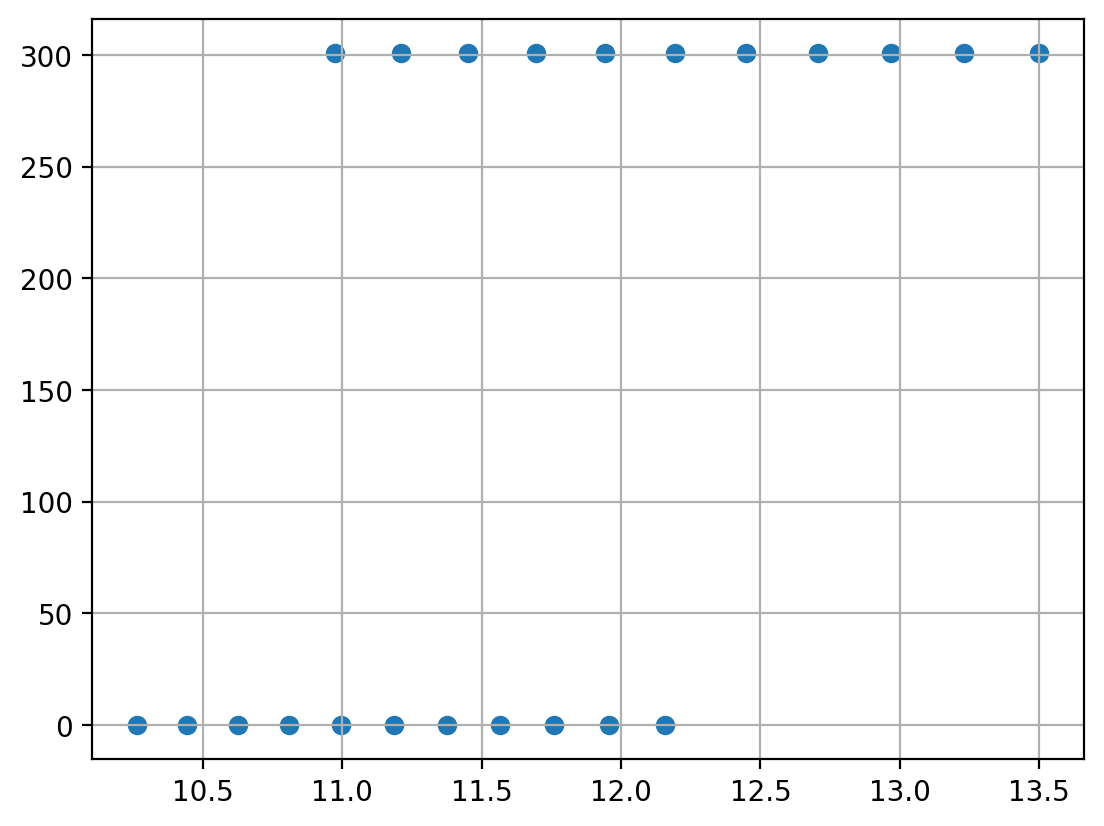

In [49]:
plt.grid()
# plt.scatter(volumes, coef_lst[:, 0])
cond = np.ptp(m_lst, axis=-1) < 0.01
# plt.scatter(v_lst[cond], E_lst[cond] / 4)
n_atoms = 2
if cs == "fcc":
    n_atoms = 4
plt.scatter(np.sort(v_lst[cond]), E_lst[cond][np.argsort(v_lst[cond])] / n_atoms - coef_lst[:, 0])

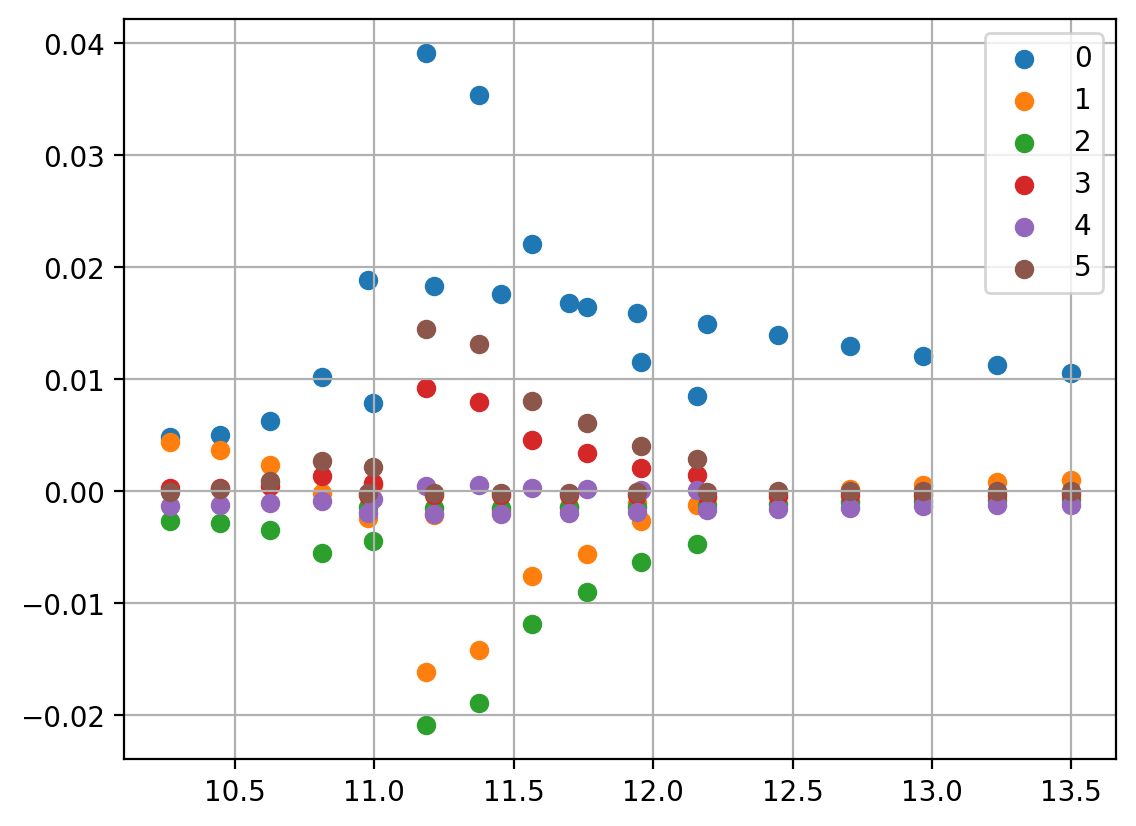

In [50]:
plt.grid()
for i in range(m_lst.shape[1]):
    plt.scatter(volumes, coef_lst[:, i + 1], label=i)
plt.legend();


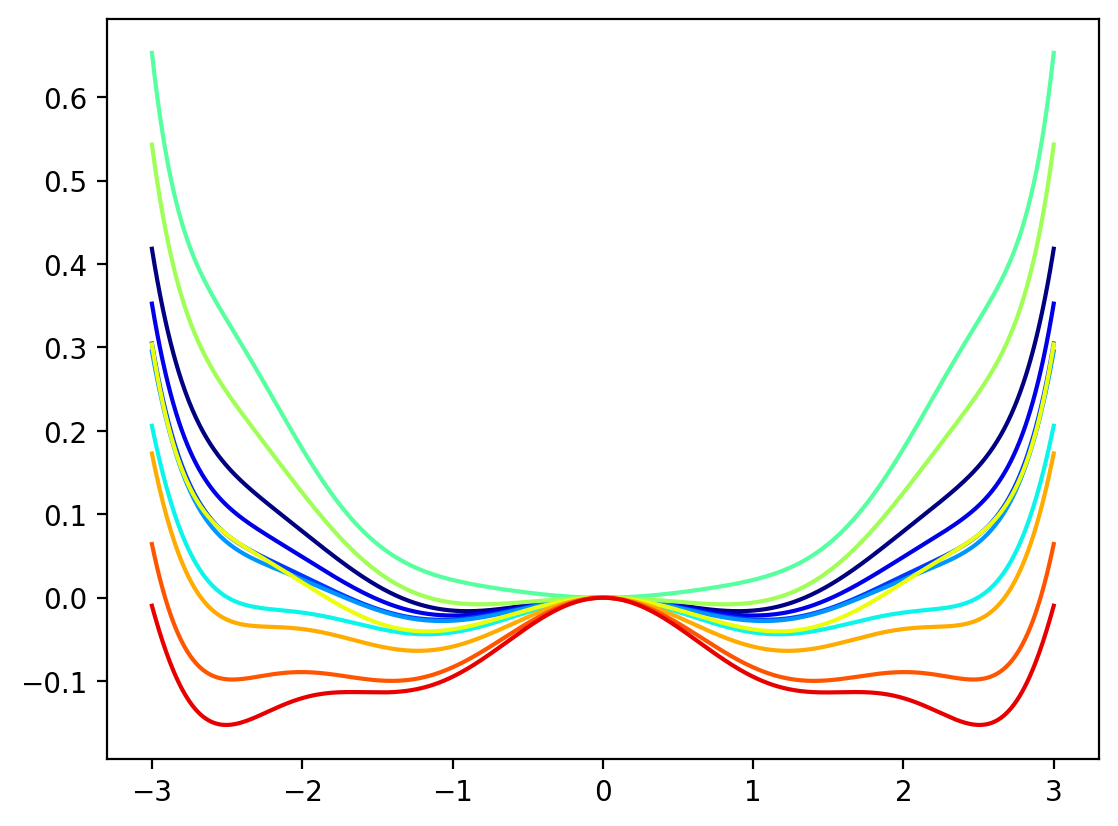

In [25]:
m = np.linspace(-1, 1, 1000) * 3
for ii, cc in enumerate(coef_lst):
    plt.plot(m, np.polyval(np.append(cc[-max_exp:][::-1], 0), m**2), c=plt.cm.jet(ii / len(coef_lst)));

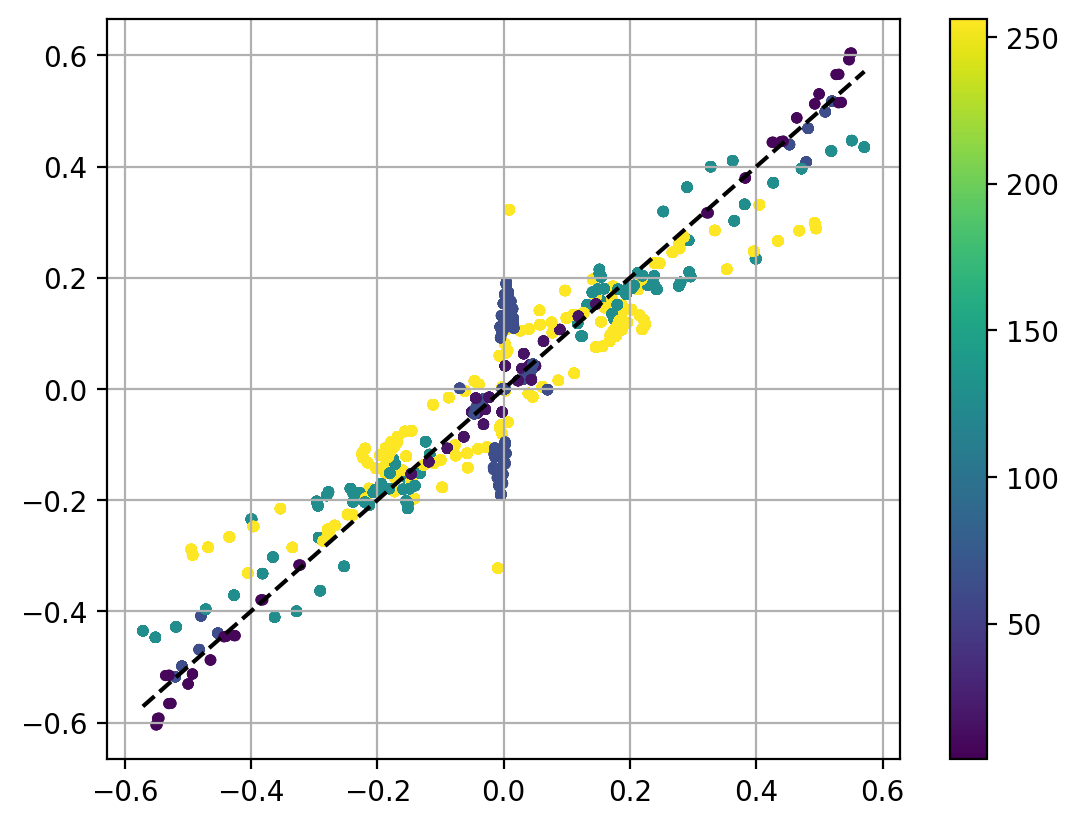

In [26]:
_, indices, inverse = np.unique(np.round(v_rep_lst, decimals=3), return_index=True, return_inverse=True)

coeff_lst = []
for ind, ii in enumerate(np.unique(inverse)):
    x = np.einsum("ijk->jik", m_all_lst[ii == inverse]).reshape(s_count, -1).T
    y = f_lst[ii == inverse].flatten()
    n = n_rep_lst[ii == inverse].flatten()
    reg = RidgeCV(fit_intercept=False, alphas=np.logspace(-1, 4, 11))
    reg.fit(x, y, sample_weight=1 / n)
    coeff_lst.append(reg.coef_)
    # plt.scatter(y, y - reg.predict(x), marker=".", c=n)
    plt.scatter(y, reg.predict(x), marker=".", c=n)
plt.colorbar()
coeff_lst = np.array(coeff_lst)
plt.grid();
plt.plot(* 2 * [[f_lst.min(), f_lst.max()]], "--", color="black")


In [144]:
class Symmetry:
    def __init__(self, cs):
        structure = Structure(a=3, crystalstructure=cs)
        self.structure = structure.n.repeat(structure.repeat)
        
    @cached_property
    def symmetry(self):
        return self.structure.get_symmetry()
    
    @cached_property
    def displacements(self):
        displacements = np.zeros_like(self.structure.positions)
        displacements[0, 0] += 0.01
        return self.symmetrize_vector(displacements)
    
    @cached_property
    def x_outer(self):
        return np.einsum("ik,ij->kj", *2 * [self.displacements])
        
    def symmetrize_vector(self, vec):
        return np.einsum(
            "nxy,nmy->nmx",
            self.symmetry.rotations,
            vec[self.symmetry.permutations],
        ).reshape(-1, np.prod(self.structure.positions.shape))
    
    def symmetrize_scalar(self, sca):
        return sca[self.symmetry.permutations]
    
    def get_hessian(self, forces):
        H = -np.einsum(
            "kj,in,ik->nj",
            np.linalg.inv(self.x_outer),
            self.symmetrize_vector(forces),
            self.displacements,
            optimize=True,
        )   
        return 0.5 * (H + H.T)


In [145]:
sym = Symmetry("fcc")

In [146]:
df = get_job_table()

In [147]:
job_lst = []
E_lst = []
for job_name in tqdm(df[df.job.str.startswith("fcc") & (df.chemicalformula=="Fe4")].job):
    job = pr.load(job_name)
    if "atom_spins" in job.output.generic.dft and np.all(job.output.generic.dft.atom_spins > 0) and not job.fix_spin_constraint:
        job_lst.append(job_name)
        E_lst.append([job.structure.cell[0, 0], job.output.energy_pot[-1]])
E_lst = np.array(E_lst)

  0%|          | 0/154 [00:00<?, ?it/s]

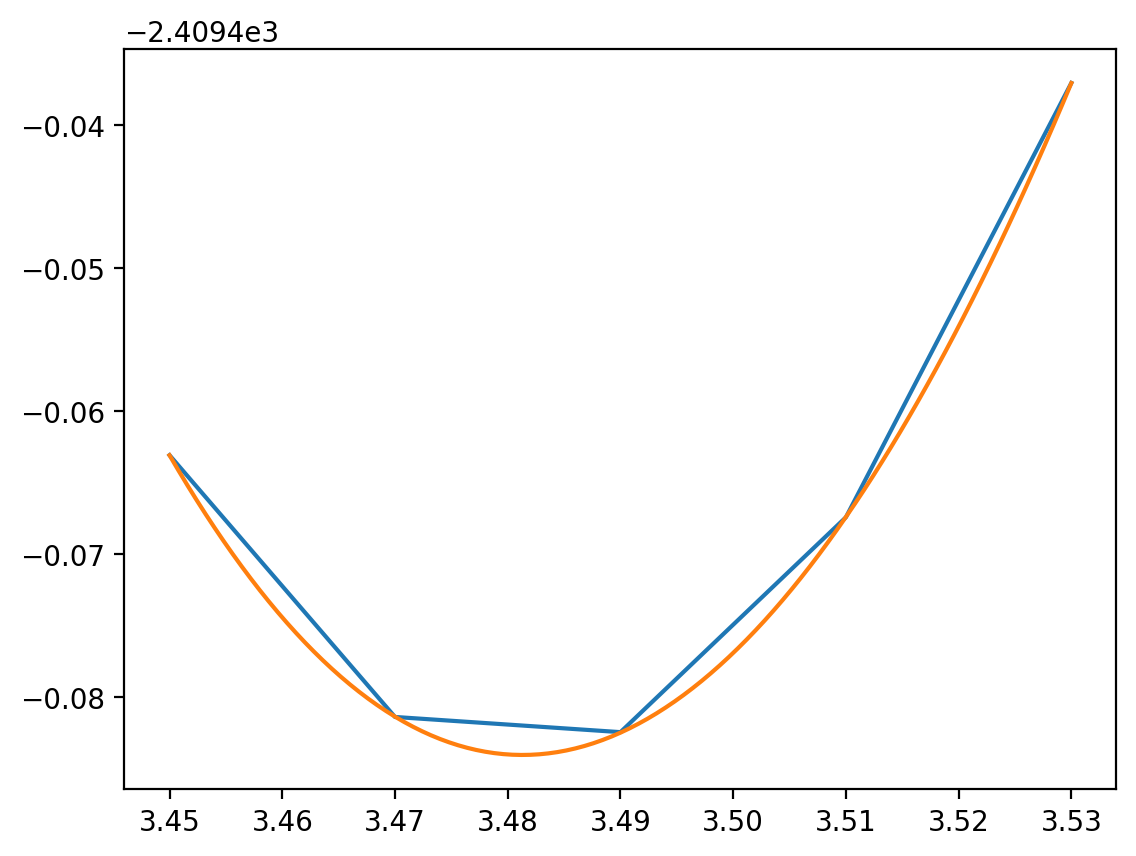

In [148]:
coeff = np.polyfit(*E_lst[E_lst[:, 0].argsort()][:5].T, 3)
plt.plot(*E_lst[E_lst[:, 0].argsort()][:5].T);
a_lst = np.linspace(3.45, 3.53, 101)
plt.plot(a_lst, np.polyval(coeff, a_lst));

In [149]:
a_lst[np.polyval(coeff, a_lst).argmin()]

3.4812

In [150]:
E_lst = []
job_lst = []
for job_name in tqdm(df[df.chemicalformula=="Fe256"].job):
    job = pr.load(job_name)
    if "atom_spins" in job.output.generic.dft and np.all(job.output.generic.dft.atom_spins > 0):
        job_lst.append(job_name)

  0%|          | 0/162 [00:00<?, ?it/s]

In [151]:
f_lst = []
L_lst = []
H_lst = []
for job_name in job_lst:
    job = pr.load(job_name)
    if "forces" in job.output.generic:
        f_lst.extend(job.output.generic.forces)
        L_lst.append(job.structure.cell[0, 0] / 4)
        H_lst.append(sym.get_hessian(f_lst[-1]))

In [ ]:
H = np.einsum("minj->nmij", H_lst[2].reshape(2 * x[0].shape)).reshape(-1, 3, 3)

In [ ]:
plt.scatter(
    np.linalg.norm(x, axis=-1),
    np.ptp(H, axis=(-1, -2))
)

In [ ]:
plt.plot(np.array(H_lst)[:, 0], '-o');

In [ ]:
plt.plot(np.linalg.eigh(H_lst)[0].T);

In [ ]:
plt.imshow(H)

In [ ]:
H_lst